In [1]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import importlib

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions, preprocess_input


Using TensorFlow backend.


In [ ]:
?preprocess_input

In [2]:
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import tarfile, tensorflow as tf, matplotlib.pyplot as plt, xgboost, operator, random, pickle, glob, os
import shutil, sklearn, functools, itertools, scipy
from PIL import Image


/home/rajat/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import cv2
import tqdm

In [ ]:
!wget http://files.fast.ai/data/imagenet-sample-train.tar.gz

In [4]:
import tarfile

In [5]:
fname='imagenet-sample-train.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

KeyboardInterrupt: 

In [6]:
path='train/'

img_list = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(img_list); n



19439

In [6]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [8]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [7]:
def read_image(img_path,H,W):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (W,H)) # you can resize to  (128,128) or (256,256)
    return img


In [23]:
image_lr=[]
img='C_0002.jpg'
image_lr.append(read_image(img,72,72))
arr_lr=np.array(image_lr)
arr_lr.shape
image_hr=[]
img='C_0002.jpg'
image_hr.append(read_image(img,288,288))
arr_hr=np.array(image_hr)
arr_hr.shape

(1, 288, 288, 3)

In [10]:
image_lr=[]
image_hr=[]

TRAIN_PATH='/train/*'

for img in img_list:
    image_lr.append(read_image(img,72,72))
    
for img in img_list:
    image_hr.append(read_image(img,288,288))

In [11]:
arr_lr = np.array(image_lr)
arr_hr = np.array(image_hr)

In [12]:
print(arr_lr.shape)
print(arr_hr.shape)


(19439, 72, 72, 3)
(19439, 288, 288, 3)


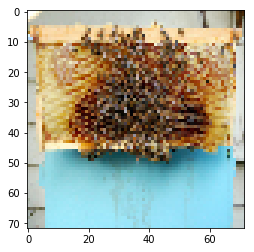

In [13]:
plt.imshow(arr_lr[7])

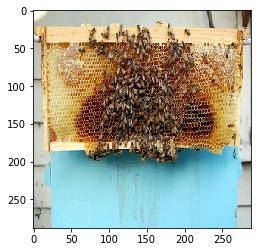

In [14]:
plt.imshow(arr_hr[7])

In [ ]:

img_lr=[]
img='image_lr'
img_lr.append(read_image('{}.png'.format(img),72,72))

img_lr = np.array(img_lr, np.float32)/255
img_lr.shape

In [ ]:

img_hr=[]
img='image_lr'
img_hr.append(read_image('{}.png'.format(img),288,288))

img_hr = np.array(img_hr, np.float32)/255
img_hr.shape

In [18]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=0)(x)
    return Activation('relu')(x) if act else x

In [19]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [20]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=0)(x)
    return Activation('relu')(x)

In [21]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=0)(x)
    return Activation('relu')(x)

In [24]:
arr_lr.shape

(1, 72, 72, 3)

In [25]:
inp=Input(arr_lr.shape[1:])

x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [26]:
model=Model(inp,outp)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 72, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 72, 72, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 72, 72, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [27]:
vgg_inp=Input(arr_hr.shape[1:])

In [28]:
vgg_inp.shape

TensorShape([Dimension(None), Dimension(288), Dimension(288), Dimension(3)])

In [29]:

vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [30]:
for l in vgg.layers: l.trainable=False


In [31]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [ ]:

preproc_layer = Lambda(preproc)


In [32]:


# get the vgg output 
vgg_out_layer = vgg.get_layer('block2_conv2').output

# making model Model(inputs, outputs)
vgg_content = Model(vgg_inp, vgg_out_layer)

vgg_content.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
Total para

In [34]:


# this is the VGG model with the HR input
vgg_hr_image = vgg_content(vgg_inp)

# this is the upsampled network
vgg_it_op = vgg_content(outp)



In [35]:
vgg_hr_image.shape

TensorShape([Dimension(None), Dimension(144), Dimension(144), Dimension(128)])

In [36]:
vgg_it_op.shape

TensorShape([Dimension(None), Dimension(144), Dimension(144), Dimension(128)])

In [31]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

NameError: name 'TQDMNotebookCallback' is not defined

In [37]:
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg_hr_image, vgg_it_op])

In [ ]:
'''
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)


w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res



m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))



'''



In [38]:
sr_model = Model([inp, vgg_inp], loss)
sr_model.compile('adam', 'mse')

In [39]:
sr_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 72, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 72, 72, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 72, 72, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [40]:
targ = np.zeros((arr_hr.shape[0], 128))
targ.shape

(1, 128)

In [42]:

K.set_value(sr_model.optimizer.lr, 1e-4)
sr_model.fit([arr_lr, arr_hr], targ, 16, 1)




Epoch 1/1
19439/19439 [==============================] - 2138s - loss: 113644.4296  


In [43]:
K.set_value(sr_model.optimizer.lr, 1e-3)
sr_model.fit([arr_lr, arr_hr], targ, 16, 1)


Epoch 1/1
19439/19439 [==============================] - 2096s - loss: 85722.6642  


In [41]:


top_model = Model(inp, outp)



In [42]:
top_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 72, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 72, 72, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 72, 72, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [46]:
p = top_model.predict(arr_lr[10:11])

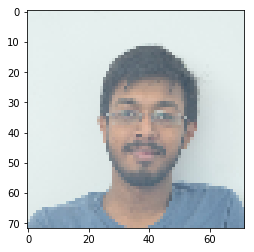

In [50]:
plt.imshow(arr_lr[0].astype('uint8'));

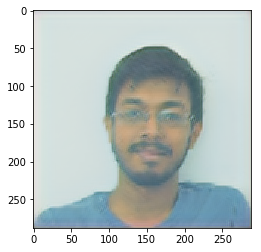

In [51]:
plt.imshow(p[0].astype('uint8'));

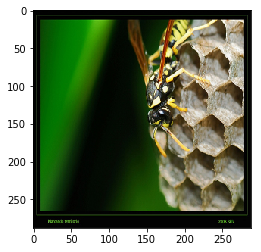

In [49]:
plt.imshow(arr_hr[10].astype('uint8'));

In [54]:


top_model.save_weights('sr_final.h5')




In [59]:
sr_model.save_weights('sr_main_model.h5')

In [46]:
def save_model(model):    
    json_string = model.to_json()
    open('model_resnet.json', 'w').write(json_string)
    model.save_weights('final_model_weight.h5', overwrite=True)        



def load_model(model):
    #model = model_from_json(open('model_finetune.json').read())
    model.load_weights('pretrained-weight/sr_final.h5')
    #model.compile(optimizer=rmsprop, loss='mse')
    return model    



In [47]:
model=load_model(top_model)

In [49]:
p=model.predict(arr_lr)

In [60]:
from IPython.display import FileLink, FileLinks
FileLink('sr_main_model.h5')

/output/sr_main_model.h5